In [1]:
# 📥 pip install cryptocompare
import cryptocompare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import tensorflow as tf

2025-08-20 00:21:36.399033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 00:21:36.563497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_ve

In [2]:
# Precios históricos
btc_history = cryptocompare.get_historical_price_hour('BTC', 'USD', limit=2000)
# Convertir tu lista de diccionarios a DataFrame
btc_df = pd.DataFrame(btc_history)

# Convertir timestamp a datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['time'], unit='s')
btc_df = btc_df.sort_values('timestamp').reset_index(drop=True)
btc_df.head(2)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
0,1748466000,107581.97,107204.87,107346.00,505.98,54340846.21,107529.37,direct,,2025-05-28 21:00:00
1,1748469600,107530.05,107182.94,107529.37,416.90,44761483.18,107435.23,direct,,2025-05-28 22:00:00


🎯 RESUMEN VELA BTC:
📅 Fecha: 2025-05-28 21:00:00
💰 Apertura: $107,346.00
📈 Máximo: $107,581.97
📉 Mínimo: $107,204.87
🎯 Cierre: $107,529.37
📊 Volumen: 505.98 BTC ($54,340,846)
📶 Tendencia: 🟢 ALCISTA
📏 Rango: $377.10
🔄 Cambio: +0.17%


0          NaN
1       -94.14
2       385.88
3       481.64
4      -100.58
         ...  
1996   -211.74
1997    449.81
1998     80.75
1999    105.02
2000   -119.89
Name: close, Length: 2001, dtype: float64

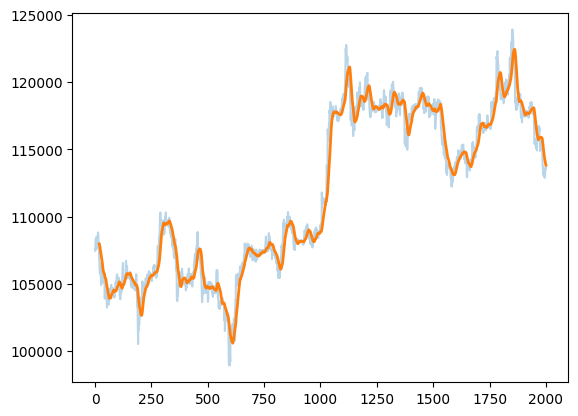

In [3]:
def print_resumen(fila):
    print("🎯 RESUMEN VELA BTC:")
    print("=" * 40)
    print(f"📅 Fecha: {fila['timestamp']}")
    print(f"💰 Apertura: ${fila['open']:,.2f}")
    print(f"📈 Máximo: ${fila['high']:,.2f}") 
    print(f"📉 Mínimo: ${fila['low']:,.2f}")
    print(f"🎯 Cierre: ${fila['close']:,.2f}")
    print(f"📊 Volumen: {fila['volumefrom']:,.2f} BTC (${fila['volumeto']:,.0f})")
    
    # Análisis adicional
    tendencia = "🟢 ALCISTA" if fila['close'] > fila['open'] else "🔴 BAJISTA"
    rango = fila['high'] - fila['low']
    cambio = ((fila['close'] - fila['open']) / fila['open']) * 100
    
    print(f"📶 Tendencia: {tendencia}")
    print(f"📏 Rango: ${rango:,.2f}")
    print(f"🔄 Cambio: {cambio:+.2f}%")

print_resumen(btc_df.iloc[0])

precios = btc_df['close'].values
plt.plot(precios, alpha=0.3, label='Precio Real (ruidoso)')

sma_20 = btc_df['close'].rolling(window=20).mean()
plt.plot(sma_20, linewidth=2, label='SMA 20 (suavizado)')
btc_df['close'].diff()

In [4]:
def crear_caracteristicas_tecnicas(df):
    """
    Crea indicadores técnicos para trading
    """
    # Precio de cierre como referencia
    df['price'] = df['close']
    
    # Medias móviles
    df['sma_7'] = df['close'].rolling(window=7).mean()    
    df['sma_25'] = df['close'].rolling(window=25).mean() 
    df['sma_50'] = df['close'].rolling(window=50).mean()  
    
    # Bandas de Bollinger
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp12 = df['close'].ewm(span=12, adjust=False).mean()
    exp26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp12 - exp26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Volatilidad
    df['volatility'] = df['close'].rolling(window=20).std()
    
    # Volume indicators
    df['volume_sma'] = df['volumefrom'].rolling(window=20).mean()
    df['volume_ratio'] = df['volumefrom'] / df['volume_sma']
    
    # Returns
    df['daily_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Target: Precio futuro (1 periodo adelante)
    df['target_price'] = df['close'].shift(-1)
    df['target_return'] = df['daily_return'].shift(-1)
    df['target_direction'] = np.where(df['target_return'] > 0, 1, 0)  # 1=sube, 0=baja
    
    return df

In [5]:
# Aplicar características técnicas
btc_df = crear_caracteristicas_tecnicas(btc_df)

# Eliminar filas con NaN (de las medias móviles)
btc_df = btc_df.dropna()

print(f"Dataset shape: {btc_df.shape}")
print(btc_df[['timestamp', 'close', 'sma_7', 'rsi', 'macd', 'target_direction']].head())

Dataset shape: (1951, 29)
             timestamp      close          sma_7        rsi        macd  \
49 2025-05-30 22:00:00  104018.35  104415.417143  38.517790 -562.645137   
50 2025-05-30 23:00:00  104039.27  104436.250000  32.937142 -582.909819   
51 2025-05-31 00:00:00  104000.46  104411.105714  28.243419 -595.239814   
52 2025-05-31 01:00:00  103529.41  104214.380000  25.829831 -635.693345   
53 2025-05-31 02:00:00  103229.12  104010.944286  25.270706 -684.098096   

    target_direction  
49                 1  
50                 0  
51                 0  
52                 0  
53                 1  


In [6]:

# Seleccionar características para el modelo
features = [
    'open', 'high', 'low', 'close', 'volumefrom', 'volumeto',
    'sma_7', 'sma_25', 'sma_50', 'bb_upper', 'bb_lower', 'rsi',
    'macd', 'macd_signal', 'volatility', 'volume_ratio', 'daily_return'
]

targets = ['target_price', 'target_return', 'target_direction']

# Datos para el modelo
X = btc_df[features].values
y = btc_df[targets].values

# Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [7]:
# Crear secuencias temporales
def crear_secuencias_btc(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])  # Predecir el siguiente punto
    return np.array(X_seq), np.array(y_seq)

window_size = 30  # 30 periodos históricos
X_seq, y_seq = crear_secuencias_btc(X_scaled, y, window_size)

print(f"X_seq shape: {X_seq.shape}")  # (muestras, 30, 17 características)
print(f"y_seq shape: {y_seq.shape}")  # (muestras, 3 targets)

X_seq shape: (1921, 30, 17)
y_seq shape: (1921, 3)


In [8]:
class TradingEnsemble:
    def __init__(self, window_size=30, n_features=17):
        self.window_size = window_size
        self.n_features = n_features
        self.models = {}
        self.scaler = MinMaxScaler()
        self.is_fitted = False
    
    def initialize_models(self):
        """Inicializa todos los modelos del ensemble"""
        # 1. Tree-based models
        self.models['xgb'] = MultiOutputRegressor(XGBRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
        ))
        
        self.models['lgbm'] = MultiOutputRegressor(LGBMRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
        ))
        
        self.models['rf'] = MultiOutputRegressor(RandomForestRegressor(
            n_estimators=100, max_depth=10, random_state=42
        ))
        
        self.models['gboost'] = MultiOutputRegressor(GradientBoostingRegressor(
            n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42
        ))
        
        # 2. Neural Networks
        self.models['lstm_price'] = self._create_lstm_model(2) 
        self.models['lstm_direction'] = self._create_lstm_classifier()
        
        # 3. Meta-model for stacking
        self.meta_model = MultiOutputRegressor(LinearRegression())
        
    def _create_lstm_model(self, output_dim):
        """Crea modelo LSTM para regresión"""
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(self.window_size, self.n_features)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model
    
    def _create_lstm_classifier(self):
        """Crea modelo LSTM para clasificación"""
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(self.window_size, self.n_features)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def prepare_ensemble_data(self, btc_df, features, targets):
        """
        Prepara datos para todos los modelos del ensemble
        """

        X = btc_df[features].values
        y = btc_df[targets].values
        
        X_scaled = self.scaler.fit_transform(X)

        X_seq, y_seq = self._create_sequences(X_scaled, y)
        
        X_2d = X_scaled[self.window_size:] 
        
        split_idx = int(len(X_seq) * 0.8)
        
        self.X_train_seq = X_seq[:split_idx]
        self.X_test_seq = X_seq[split_idx:]
        self.y_train_seq = y_seq[:split_idx]
        self.y_test_seq = y_seq[split_idx:]
        
        self.X_train_2d = X_2d[:split_idx]
        self.X_test_2d = X_2d[split_idx:]
        self.y_train_2d = y_seq[:split_idx]
        self.y_test_2d = y_seq[split_idx:]
        
        return True

    def _create_sequences(self, X, y):
        """Crea secuencias temporales"""
        X_seq, y_seq = [], []
        for i in range(len(X) - self.window_size):
            X_seq.append(X[i:i + self.window_size])
            y_seq.append(y[i + self.window_size])
        return np.array(X_seq), np.array(y_seq)
    
    def train_ensemble(self):
        """Entrena todos los modelos del ensemble"""
        print("🏗️ Entrenando ensemble de trading...")
        
        # 1. Entrenar tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                print(f"Entrenando {name}...")
                model.fit(self.X_train_2d, self.y_train_2d)
        
        # 2. Entrenar LSTM models
        print("Entrenando LSTM price...")
        self.models['lstm_price'].fit(
            self.X_train_seq, self.y_train_seq[:, :2],
            epochs=100, batch_size=32, validation_split=0.2, verbose=0
        )
        
        print("Entrenando LSTM direction...")
        self.models['lstm_direction'].fit(
            self.X_train_seq, self.y_train_seq[:, 2],  
            epochs=100, batch_size=32, validation_split=0.2, verbose=0
        )
        
        # 3. Crear meta-features para stacking
        print("Creando meta-features...")
        X_meta_train = self._create_meta_features(self.X_train_2d, self.X_train_seq)
        X_meta_test = self._create_meta_features(self.X_test_2d, self.X_test_seq)
        
        # 4. Entrenar meta-modelo
        print("Entrenando meta-modelo...")
        self.meta_model.fit(X_meta_train, self.y_train_2d)
        
        self.is_fitted = True
        print("✅ Ensemble entrenado exitosamente!")

    def _create_meta_features(self, X_2d, X_seq):
        """Crea meta-features de todas las predicciones"""
        meta_features = []
        
        # Predicciones de tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                pred = model.predict(X_2d)
                meta_features.append(pred)
        
        # Predicciones de LSTM
        lstm_price_pred = self.models['lstm_price'].predict(X_seq)
        lstm_dir_pred = self.models['lstm_direction'].predict(X_seq)
        
        # Combinar predicciones LSTM
        lstm_combined = np.column_stack([lstm_price_pred, lstm_dir_pred])
        meta_features.append(lstm_combined)
        
        return np.hstack(meta_features)


    def predict_ensemble(self, X_2d, X_seq):
        """Predice usando todo el ensemble"""
        if not self.is_fitted:
            raise ValueError("Ensemble no está entrenado. Llama a train_ensemble() primero.")
        
        # 1. Obtener meta-features
        X_meta = self._create_meta_features(X_2d, X_seq)
        
        # 2. Predecir con meta-modelo
        ensemble_pred = self.meta_model.predict(X_meta)
        
        return ensemble_pred

    def predict_proba_direction(self, X_seq):
        """Predice probabilidad de dirección (especializado)"""
        return self.models['lstm_direction'].predict(X_seq)

    def predict_next(self, recent_data):
        """Predice el próximo período"""
        # Preparar datos recientes
        recent_scaled = self.scaler.transform(recent_data)
        
        # Crear secuencia
        if len(recent_scaled) < self.window_size:
            raise ValueError(f"Se necesitan {self.window_size} períodos, se tienen {len(recent_scaled)}")
        
        X_seq = recent_scaled[-self.window_size:].reshape(1, self.window_size, self.n_features)
        X_2d = recent_scaled[-1:].reshape(1, -1)
        
        # Predecir
        prediction = self.predict_ensemble(X_2d, X_seq)
        direction_proba = self.predict_proba_direction(X_seq)[0][0]
        
        return {
            'predicted_price': prediction[0][0],
            'predicted_return': prediction[0][1],
            'direction_probability': direction_proba,
            'direction': 'UP' if direction_proba > 0.5 else 'DOWN'
        }

    def evaluate_ensemble(self):
        """Evalúa todo el ensemble"""
        if not self.is_fitted:
            raise ValueError("Ensemble no está entrenado")
        
        # Predecir en test
        ensemble_pred = self.predict_ensemble(self.X_test_2d, self.X_test_seq)
        
        # Métricas para regresión (price + return)
        mae_price = mean_absolute_error(self.y_test_2d[:, 0], ensemble_pred[:, 0])
        mae_return = mean_absolute_error(self.y_test_2d[:, 1], ensemble_pred[:, 1])
        
        # Métrica para clasificación (direction)
        pred_direction = (ensemble_pred[:, 2] > 0.5).astype(int)
        accuracy = accuracy_score(self.y_test_2d[:, 2], pred_direction)
        
        # Métricas individuales
        individual_metrics = self._evaluate_individual_models()
        
        return {
            'ensemble': {
                'price_mae': mae_price,
                'return_mae': mae_return,
                'direction_accuracy': accuracy
            },
            'individual': individual_metrics
        }

    def _evaluate_individual_models(self):
        """Evalúa cada modelo individualmente"""
        metrics = {}
        
        # Evaluar tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                pred = model.predict(self.X_test_2d)
                mae = mean_absolute_error(self.y_test_2d[:, 0], pred[:, 0])
                metrics[name] = {'price_mae': mae}
        
        # Evaluar LSTM
        lstm_price_pred = self.models['lstm_price'].predict(self.X_test_seq)
        lstm_mae = mean_absolute_error(self.y_test_seq[:, 0], lstm_price_pred[:, 0])
        metrics['lstm_price'] = {'price_mae': lstm_mae}
        
        lstm_dir_pred = self.models['lstm_direction'].predict(self.X_test_seq)
        lstm_acc = accuracy_score(self.y_test_seq[:, 2], (lstm_dir_pred > 0.5).astype(int))
        metrics['lstm_direction'] = {'accuracy': lstm_acc}
        
        return metrics

In [9]:

# Inicializar ensemble
trading_ensemble = TradingEnsemble(window_size=30, n_features=len(features))
trading_ensemble.initialize_models()

# Preparar datos
trading_ensemble.prepare_ensemble_data(btc_df, features, targets)

# Entrenar
trading_ensemble.train_ensemble()


E0000 00:00:1755667301.515806  192008 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1755667301.530352  192008 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🏗️ Entrenando ensemble de trading...
Entrenando xgb...
Entrenando lgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 17
[LightGBM] [Info] Start training from score 110736.213582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Entrenando meta-modelo...
✅ Ensemble entrenado exitosamente!


In [10]:
# Evaluar
metrics = trading_ensemble.evaluate_ensemble()
print("📊 Métricas del Ensemble:")
print(f"MAE Precio: {metrics['ensemble']['price_mae']:.4f}")
print(f"Accuracy Dirección: {metrics['ensemble']['direction_accuracy']:.3f}")

# Predecir próximo período
ultimos_datos = btc_df[features].tail(30)
prediccion = trading_ensemble.predict_next(ultimos_datos)

print(f"\n🎯 Predicción Próximo Período:")
print(f"Precio estimado: ${prediccion['predicted_price']:,.2f}")
print(f"Probabilidad subida: {prediccion['direction_probability']:.3f}")
print(f"Dirección: {prediccion['direction']}")

 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 6/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
📊 Métricas del Ensemble:
MAE Precio: 416.4739
Accuracy Dirección: 0.439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

🎯 Predicción Próximo Período:
Precio estimado: $114,351.55
Probabilidad subida: 0.621
Dirección: UP
